In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import plotly.express as px
import plotly.graph_objects as go

# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook, save
# from bokeh.models import ColumnDataSource
# from bokeh.transform import cumsum
# from bokeh.io import curdoc


In [2]:
ca_df = pd.read_csv('./comcast_consumeraffairs_complaints.csv')
ca_df.head()

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...


In [3]:
fcc_df = pd.read_csv('./comcast_fcc_complaints_2015.csv')
fcc_df.head()

,Ticket #,Customer Complaint,Date,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Description
0,250635,Comcast Cable Internet Speeds,4/22/2015,3:53:50 PM,Internet,Abingdon,Maryland,21009,Closed,No,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,4/18/2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,5/26/2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,I have been a customer of Comcast of some sort...


In [4]:
csat = len(ca_df.loc[ca_df['rating']>=4])/len(ca_df)
print("Comcast's Customer Satisfaction Score calculated from ConsumerAffairs is {:.2f}%".format(csat*100))

Comcast's Customer Satisfaction Score calculated from ConsumerAffairs is 0.90%


In [5]:
# peacock_theme = ['#cc004c','#f37021','#fcb711','#6460aa','#0089d0','#0db14b','#ffc0cb','#00ffff']

In [6]:
rating_df = pd.DataFrame({'class': ['0', '1', '2', '3', '4', '5'],
                          'percent' : ca_df['rating'].value_counts(normalize=True).sort_index()*100
                          })
rating_df

,class,percent
0,0,27.566708
1,1,65.983389
2,2,4.594451
3,3,0.954232
4,4,0.335748
5,5,0.565471


In [7]:
sorted_dates = ca_df['posted_on'].sort_values().reset_index(drop=True).tolist()
rating_plt_title = 'Comcast ConsumerAffairs Ratings {} - {}'.format(sorted_dates[0], sorted_dates[-1])

fig = px.pie(rating_df, values='percent', names='class', title=rating_plt_title)

fig.show()

In [8]:
ca_df['posted_on'] = pd.to_datetime(ca_df['posted_on'])
groupby_posted_on = ca_df.groupby('posted_on').count()

ts_plt_title = 'Number of reviews per day {} - {}'.format(sorted_dates[0], sorted_dates[-1])
fig = px.line(groupby_posted_on, x=groupby_posted_on.index, y="rating", title=ts_plt_title,
              labels={
                     "x": "Year",
                      "rating": "Number of Reviews"
                 })
fig.show()

In [9]:
groupby_posted_on.loc[groupby_posted_on['rating'] > 50]

# Change pandas settings to allow max rows be 100
ca_df.loc[ca_df['posted_on'] == '2016-02-24']

,author,posted_on,rating,text
179,"Joshua of Philadelphia, PA",2016-02-24,1,My modem is directly connected to my computer....
1817,"Pene of Las Vegas, NV",2016-02-24,3,The field technician was great. However it too...
1818,"Beverly of Chesterfield, VA",2016-02-24,3,Had issue getting voice mail but customer serv...
1819,"John of Berkeley, CA",2016-02-24,3,"They're generally curious, knowledgeable, and ..."
1820,"Yvonne of Mt. Juliet, TN",2016-02-24,2,It's so difficult to reach them. I usually had...
...,...,...,...,...
1875,"Cynthia of Canton, GA",2016-02-24,1,"Minimally, it takes five minutes before you re..."
1876,"peggy of Boulder, CO",2016-02-24,1,If one wants it... one has to actually head do...
1877,"V of Gibbstown, NJ",2016-02-24,2,I had extremely slow internet for YEARS and th...
1878,"Monica of Vallejo, CA",2016-02-24,2,It takes over 5 minutes of listening to a phon...


In [10]:
fcc_df['Date'] = pd.to_datetime(fcc_df['Date'])

ca_df['Count'] = 0
ca_df2 = ca_df.loc[ca_df['posted_on'] >= '2015-01-01']
groupby_posted_on = ca_df2.groupby('posted_on').count()


fcc_df['Count'] = 0
groupby_date = fcc_df.groupby('Date').count()

fig = go.Figure()
fig.add_trace(go.Scatter(x=groupby_date.index, y=groupby_date.Count,
                    mode='lines',
                    name='# of FCC Customer Complaints'))
fig.add_trace(go.Scatter(x=groupby_posted_on.index, y=groupby_posted_on.rating,
                    mode='lines',
                    name='# of ConsumerAffairs Reviews'))
fig.show()
fcc_df = fcc_df.drop(columns="Count")

In [11]:
fcc_df['Customer Complaint'].value_counts()

Comcast                                    83
Comcast Internet                           18
Comcast Data Cap                           17
comcast                                    13
Comcast Billing                            11
                                           ..
Horrible Service                            1
Charged for speeds they can not provide     1
Bait and Switch again                       1
Wireless Internet                           1
Internet slow                               1
Name: Customer Complaint, Length: 1842, dtype: int64

In [12]:
def get_simple_topic_percentage(topic):
    """
    Returns a percentage of rows that this particular topic is found
    in using simple string manipulation. Note: this can have overlaps,
    for example if you have two topics, one 'Internet' and one 'Speed',
    you will get duplicate findings if the customer has 'Internet Speed'
    as their topic.
    
    topic: the customer complaint category entered by the customer.
    """
    return fcc_df[fcc_df['Customer Complaint'].str.contains(topic, case=False)].shape[0] / len(fcc_df['Customer Complaint']) * 100
    

print('Comcast:', get_simple_topic_percentage('comcast'))
print('Data cap:', get_simple_topic_percentage('data'))
print('Speed:', get_simple_topic_percentage('speed'))
print('Internet:', get_simple_topic_percentage('internet'))
print('Price:', get_simple_topic_percentage('price'))
print('Bill:', get_simple_topic_percentage('bill'))
print('Customer Service:', get_simple_topic_percentage('customer service'))

Comcast: 56.044943820224724
Data cap: 9.887640449438202
Speed: 8.629213483146067
Internet: 23.91011235955056
Price: 2.6516853932584272
Bill: 17.078651685393258
Customer Service: 3.50561797752809


In [13]:
!pip install wordcloud

In [14]:
from spacy.lang.en import English
nlp = English()

customize_stop_words = ['comcast', 'i', 'fcc', 'hello', 'service', 'services', 'issue', 'now', 'call', 'called', 'tell', 'said',
                        'issues', 'problem', 'problems', 'xfinity', 'customer', 'complaint', '$']
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

def preprocess(verbatim):
    """
    Tokenizes, removes stopwords, and lemmatizes a verbatim text
    
    verbatim: a free-form text complaint
    """
    # Every verbatim ends with the FCC follow up, let's remove this.
    verbatim = verbatim.split('\n')[0].lower()
    doc = nlp(verbatim)
    sent = []
    for word in doc:
        # If it's not a stop word or punctuation mark, add it to our article!
        if word.text != 'n' and not word.is_stop and not word.is_punct and not word.like_num:
            # We add the lematized version of the word
            sent.append(word.lemma_.lower())
    return sent

# Tokenize each complaint
docs = fcc_df['Description'].apply(lambda verbatim: preprocess(verbatim))

In [15]:
from wordcloud import WordCloud, STOPWORDS

for word in customize_stop_words:
    STOPWORDS.add(word)
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=1200,
                      height=1000).generate(''.join(fcc_df['Customer Complaint'].dropna().tolist()).lower())

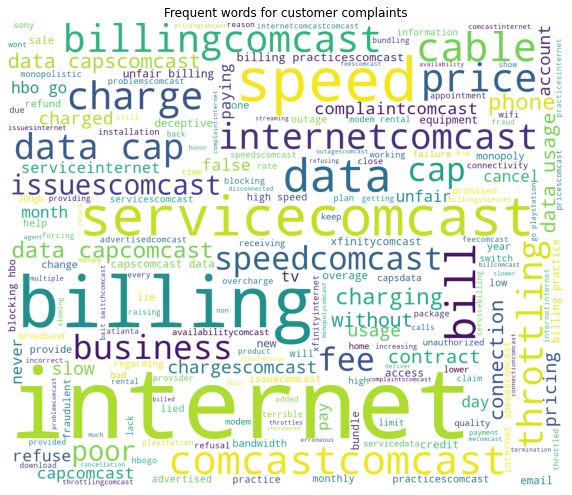

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure( figsize=(10,12) )
plt.imshow(wordcloud)
plt.title('Frequent words for customer complaints')
plt.axis('off')
plt.show()

In [17]:
docs

0       [contacting, internet, technical, support, mon...
1       [january, payments, january, february, advance...
2       [home, located, acworth, georgia, signed, year...
3       [atlanta, area, effect, unprecendented, usage,...
4                                     [sort, years, like]
                              ...                        
2220    [deaf, guy, asked, att, provide, cable, dsl, a...
2221    [purchased, modem, returned, modem, 8/12/13, r...
2222    [agreement, agent, year, mg, bite, hbo, tv, go...
2223    [months, ago, forced, finally, extremely, slow...
2224    [internet, disconnects, time, rarely, 106mbits...
Name: Description, Length: 2225, dtype: object

In [18]:
import nltk
from nltk import FreqDist
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cats = fcc_df['Customer Complaint'].apply(lambda verbatim: preprocess(verbatim))
filtered_complaints = [c for cl in cats for c in cl]
fdist = FreqDist(filtered_complaints)
print(fdist.most_common(30))

token_df = pd.DataFrame(fdist.most_common(300), columns=['Samples', 'Count'])

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=token_df.Samples, y=token_df.Count, name="top 300"),
    row=1, col=1
)

token_df = pd.DataFrame(fdist.most_common(30), columns=['Samples', 'Count'])

fig.add_trace(
    go.Scatter(x=token_df.Samples, y=token_df.Count, name="top 30"),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Word Distribution")
fig.show()

[('internet', 533), ('billing', 294), ('data', 220), ('speed', 121), ('cap', 106), ('caps', 79), ('practices', 73), ('speeds', 72), ('charges', 71), ('bill', 64), ('unfair', 59), ('cable', 56), ('throttling', 54), ('slow', 49), ('usage', 47), ('poor', 45), ('pricing', 42), ('price', 40), ('connection', 37), ('business', 33), ('contract', 30), ('phone', 30), ('false', 27), ('charged', 27), ('account', 26), ('charging', 25), ('high', 25), ('fees', 24), ('deceptive', 23), ('charge', 23)]


In [19]:
import gensim
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

print('Distinct words in initial documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.3)

print('Distinct words after removing rare and common words:', len(dictionary))

Distinct words in initial documents: 7246
Distinct words after removing rare and common words: 1146


In [21]:
!pip install pyLDAvis
import pyLDAvis
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim_models

corpus = [dictionary.doc2bow(doc) for doc in docs]
num_topics = 8

# Check for .pickle
filename = './lda_model.pickle'
model = []
found = False
try: 
    infile = open(filename,'rb')
    model = pickle.load(infile)
    infile.close()
    found = True
    print('Model found..loaded.')
except:
    print('Model not found!')

if not found:
    %time model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=200, workers=2)
    outfile = open(filename,'wb')
    pickle.dump(model, outfile)
    outfile.close()

Model not found!


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

CPU times: user 35.2 s, sys: 2.86 s, total: 38.1 s
Wall time: 38.9 s


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

In [ ]:
!pip install pandas==1.2.0
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

fcc_df_super = fcc_df.copy()

fcc_df_super['Tokens'] = docs

docs_upper = fcc_df_super['Tokens'].apply(lambda l: l[:int(len(l)/2)])
docs_lower = fcc_df_super['Tokens'].apply(lambda l: l[int(len(l)/2):])

In [ ]:
corpus_upper = [dictionary.doc2bow(doc) for doc in docs_upper]
corpus_lower = [dictionary.doc2bow(doc) for doc in docs_lower]

# Using the corpus LDA model tranformation
lda_corpus_upper = model[corpus_upper]
lda_corpus_lower = model[corpus_lower]

In [ ]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False): 
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    
    model: the LDA model
    corpus: the documents
    kwords: if True adds and returns the keys
    '''
    top_dist =[]
    keys = []
    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.asarray(vals)]
        if kwords:
            keys += [np.asarray(vals).argmax()]

    return np.asarray(top_dist), keys

In [ ]:
top_dist_upper, _ = get_doc_topic_dist(model, lda_corpus_upper)
top_dist_lower, _ = get_doc_topic_dist(model, lda_corpus_lower)

print("Intra-similarity:", np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1, c2 in zip(top_dist_upper, top_dist_lower)]))

random_pairs = np.random.randint(0, len(fcc_df_super['Description']), size=(400, 2))
print("Inter-similarity:", np.mean([cosine_similarity(top_dist_upper[0].reshape(1, -1), top_dist_lower[1].reshape(1, -1))]))


In [ ]:
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print(f'\nTopic {str(i)}\n')
    for term, frequency in model.show_topic(i, topn=10):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [ ]:
top_labels = {0: 'Pricing', 1:'Billing', 2:'Data Caps', 3:'Missed Appointments', 4:'Moving Services', 5: 'Customer Services', 6:'Internet Speed', 7: 'Business Contracts'}

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',
                                  tokenizer=preprocess, ngram_range=(1,3), min_df=40, max_df=0.20,
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(fcc_df_super['Description']).toarray()

In [ ]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names_out()

In [ ]:
top_words = []
for n in range(len(dtm)):
    inds = np.int0(np.argsort(dtm[n])[::-1][:4])
    top_words += [', '.join([features[i] for i in inds])]
    
fcc_df_super['Description Top Words'] = pd.DataFrame(top_words)
fcc_df_super['Topic'] = pd.DataFrame(lda_keys)
# Fill missing values with dummy
fcc_df_super['Topic'].fillna(-1, inplace=True)
fcc_df_super.head()

In [ ]:
fcc_df_super['Zip code'] = fcc_df_super['Zip code'].apply(str)
fcc_df_super.dtypes

In [36]:
!pip install pandas --upgrade
!pip install pgeocode
import pgeocode
nomi = pgeocode.Nominatim('us')

edf = fcc_df_super
edf['Latitude'] = (nomi.query_postal_code(edf['Zip code'].tolist()).latitude)
edf['Longitude'] = (nomi.query_postal_code(edf['Zip code'].tolist()).longitude)
edf['state_code'] = nomi.query_postal_code(edf['Zip code'].tolist()).state_code

fig = px.choropleth(edf, locations=edf['state_code'], locationmode='USA-states',
 color='Topic',
 range_color=(0, 8),scope='usa',hover_name='State', title='User Topic Complain')
fig.show()

In [ ]:
edf

In [ ]:
# !snscrape -h

In [ ]:
# !snscrape --max-results --jsonl 500 twitter-search "its the elephant since:2020-06-01 until:2020-07-31" > text-query-tweets.json

In [ ]:
# !pip3 install --upgrade git+https://github.com/JustAnotherArchivist/snscrape@master